# Business Problem Understanding

- Identify the emotions behind the tweet/text, that helps in analysing the sentiment of customers towards products/services/brands and identifying the areas that need improvement to enhace the customer satisfaction

1) Emotion detection can help in understanding the sentiment of customers towards a brand or product allowing to take necessary actions to enhance customer satisfaction. Understanding the emotional impact of marketing and ad campaigns and target the audience specifically

2) It can also help in identifying the public opinion allowing to analyze the sentiment of people towards a topic/event/etc., (political elections, social movements, or public health issues)

3) It also helps us identify mental health issues such as worry, depression, anxiety, or stress that help healthcare professionals to provide quick service

In [1]:
import numpy as np
import pandas as pd
import string
import nltk
import contractions
import inflect
import re


import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier,\
                BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('tweet_emotions.csv')
df.head()

tweet_id   sentiment                                            content
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696     sadness                Funeral ceremony...gloomy friday...
3  1956967789  enthusiasm               wants to hang out with friends SOON!
4  1956968416     neutral  @dannycastillo We want to trade with someone w...

In [3]:
print('The dataset consists of {} rows and {} columns'.format(df.shape[0], df.shape[1]))

The dataset consists of 40000 rows and 3 columns


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [5]:
df['sentiment'].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [6]:
df.describe(include='object').T

count unique                                                top  \
sentiment  40000     13                                            neutral   
content    40000  39827  I just received a mothers day card from my lov...   

           freq  
sentiment  8638  
content      14

In [7]:
lemm = WordNetLemmatizer()

- Will do some data cleaning, as the text is from tweets there is hight possibility of having mentions, hastags, numbers, contractions also any unnecessary data such as emails, links, multiple spaces or any other charecters. Proceeding further without cleaned all the above mentioned points might mislead the analysis
- Also, will use lemmatizer for now as the words should have some meaning while analyzing

In [8]:
def text_preprocess(text):
    # Replace contractions
    cleaned = contractions.fix(text)
    
    cleaned = ' '.join([word if not word.isdigit() else '' for word in cleaned.split()])
    '''
    #replace numbers with word
    cleaned = [inflect.engine().number_to_words(word) if word.isdigit() \
               else word for word in cleaned.split()]
    cleaned = ' '.join(cleaned)
    '''

    # Replace multiple dots with a single dot and remove dots if they occur more than once
    cleaned = re.sub(r'\.+', '.', cleaned)
    cleaned = re.sub(r'\.\s+\.', '', cleaned)

    # Replace dots with a space if there is no space between the words
    cleaned = re.sub(r'\.(\S)', r' \1', cleaned)

    # Remove extra spaces
    cleaned = re.sub(r'\s+', ' ', cleaned.strip())

    # Remove emails, words starting with @ and #
    cleaned = re.sub('([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})', '', cleaned)
    cleaned = re.sub(r'(?i)\b@\w\w+\b', '', cleaned)
    cleaned = re.sub(r'(?i)\b#\w\w+\b', '', cleaned)
    cleaned = re.sub(r'\b\d+\S*\b', '', cleaned) # remove words starting with a number
    
    cleaned = re.sub(r'(.)\1{2,}', r'\1\1', cleaned)

    # Remove account tags, hashtags, and links
    cleaned = re.sub(r'@[\w]+', '', cleaned)
    cleaned = re.sub(r'#[\w]+', '', cleaned)
    cleaned = re.sub(r'http[^\s]+', '', cleaned)

    cleaned = [char.lower() for char in cleaned if char not in string.punctuation]
    cleaned = ''.join(cleaned)
    cleaned = ' '.join([lemm.lemmatize(word) for word in cleaned.split() if len(word) <= 20])   

    return cleaned

In [9]:
df['content'] = df['content'].apply(text_preprocess)

In [10]:
emotion = pd.DataFrame(df['sentiment'].value_counts())
emotion

sentiment
neutral          8638
worry            8459
happiness        5209
sadness          5165
love             3842
surprise         2187
fun              1776
relief           1526
hate             1323
empty             827
enthusiasm        759
boredom           179
anger             110

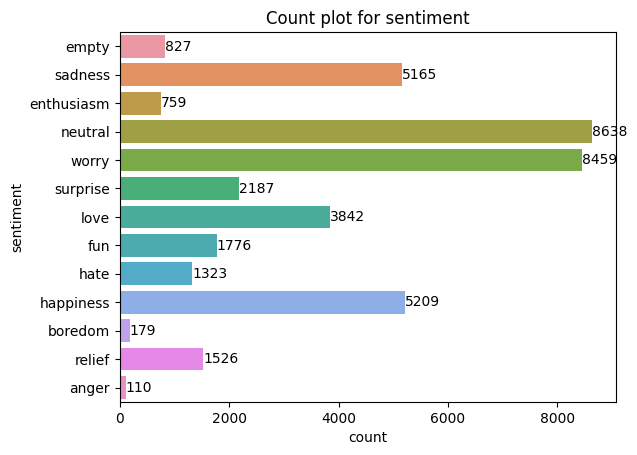

In [11]:
ax = sns.countplot(y='sentiment', data=df)
plt.title('Count plot for sentiment')

for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), 
                (p.get_width(), p.get_y() + p.get_height()/2), 
                ha = 'left', va = 'center',
                xytext = (0, 0),
                textcoords = 'offset points')

plt.show()


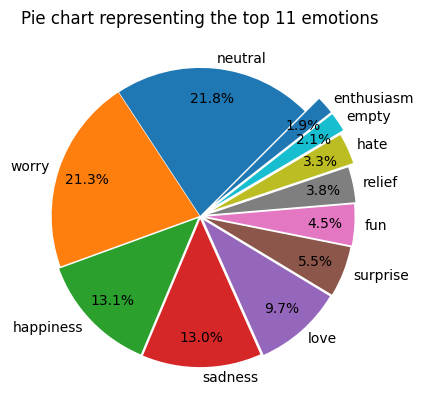

In [12]:
explode = np.array(df['sentiment'].value_counts())/len(df)
explode = list(explode)[::-1][:11]

plt.pie(emotion['sentiment'][:11], startangle=45, pctdistance = 0.8, explode = explode, 
        autopct = '%1.1f%%', labels = list(emotion.index)[:11], labeldistance=1.07, )
plt.title('Pie chart representing the top 11 emotions')
plt.show()

- 'Neutral' and 'Worry' are the most frequent emotions followed by 'Happiness', 'Sadness'

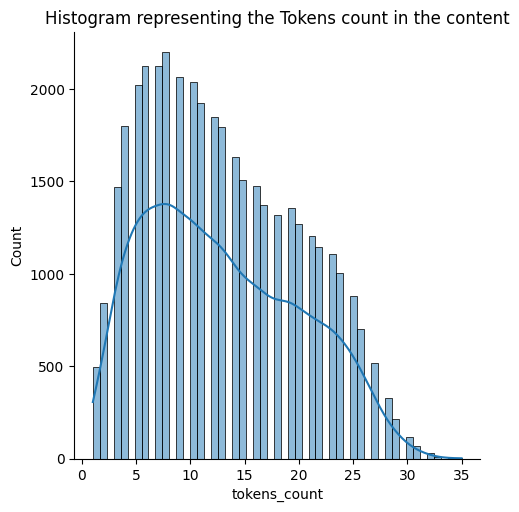

In [13]:
df['tokens_count'] = df['content'].apply(lambda x: len(x.split(' ')))

sns.displot(x = 'tokens_count', data=df, kde=True)
plt.title('Histogram representing the Tokens count in the content')
plt.show()

- We can also analyse the charecter and token length based on the sentiment which may gave any information if they are related

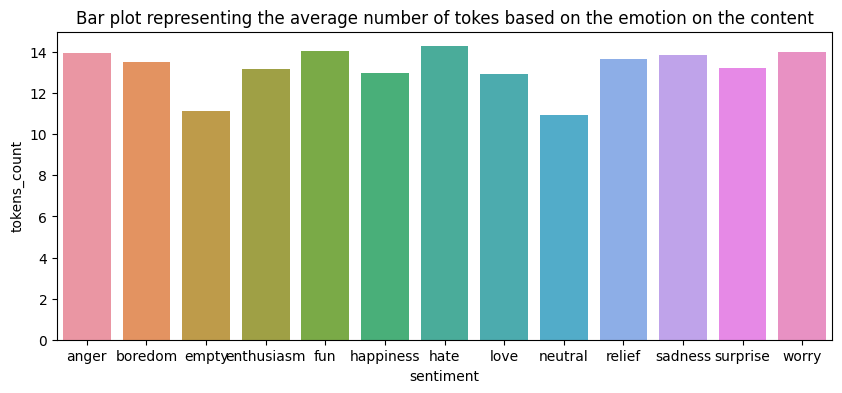

In [14]:
token_count_sentiment = pd.DataFrame(df.groupby('sentiment')['tokens_count'].agg('mean'))
plt.figure(figsize=(10,4))
sns.barplot(x = token_count_sentiment.index, y = 'tokens_count', data = token_count_sentiment)
plt.title('Bar plot representing the average number of tokes based on the emotion on the content')
plt.show()

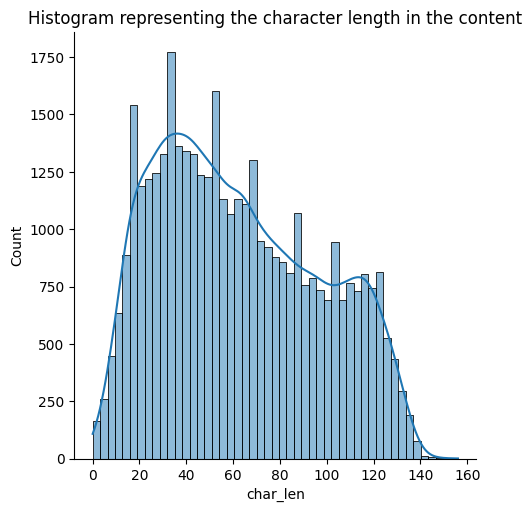

In [15]:
df['char_len'] = df['content'].apply(lambda x: len(x))

sns.displot(x = 'char_len', data=df, kde=True)
plt.title('Histogram representing the character length in the content')
plt.show()

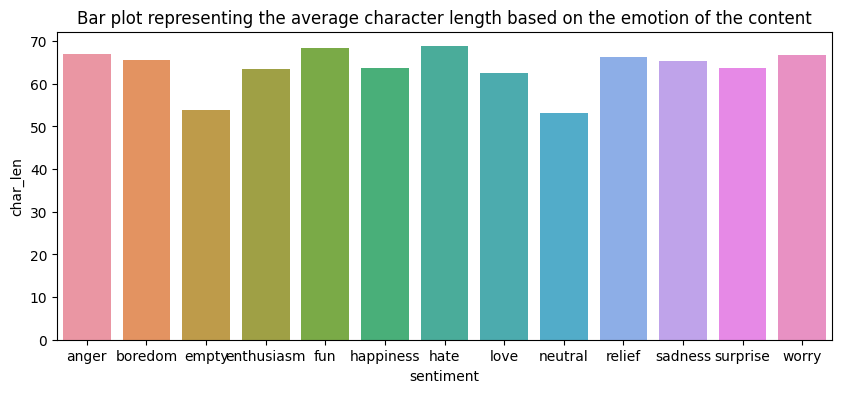

In [16]:
char_len_sentiment = pd.DataFrame(df.groupby('sentiment')['char_len'].agg('mean'))
plt.figure(figsize=(10,4))
sns.barplot(x = char_len_sentiment.index, y = 'char_len', data = char_len_sentiment)
plt.title('Bar plot representing the average character length based on the emotion of the content')
plt.show()

- From the above plots, the take aways are:
    - People with 'neutral', 'empty' write a bit less charecters compared to to other emotions
    - People with 'hate' writes some big tweets but not very huge compared to 'fun'

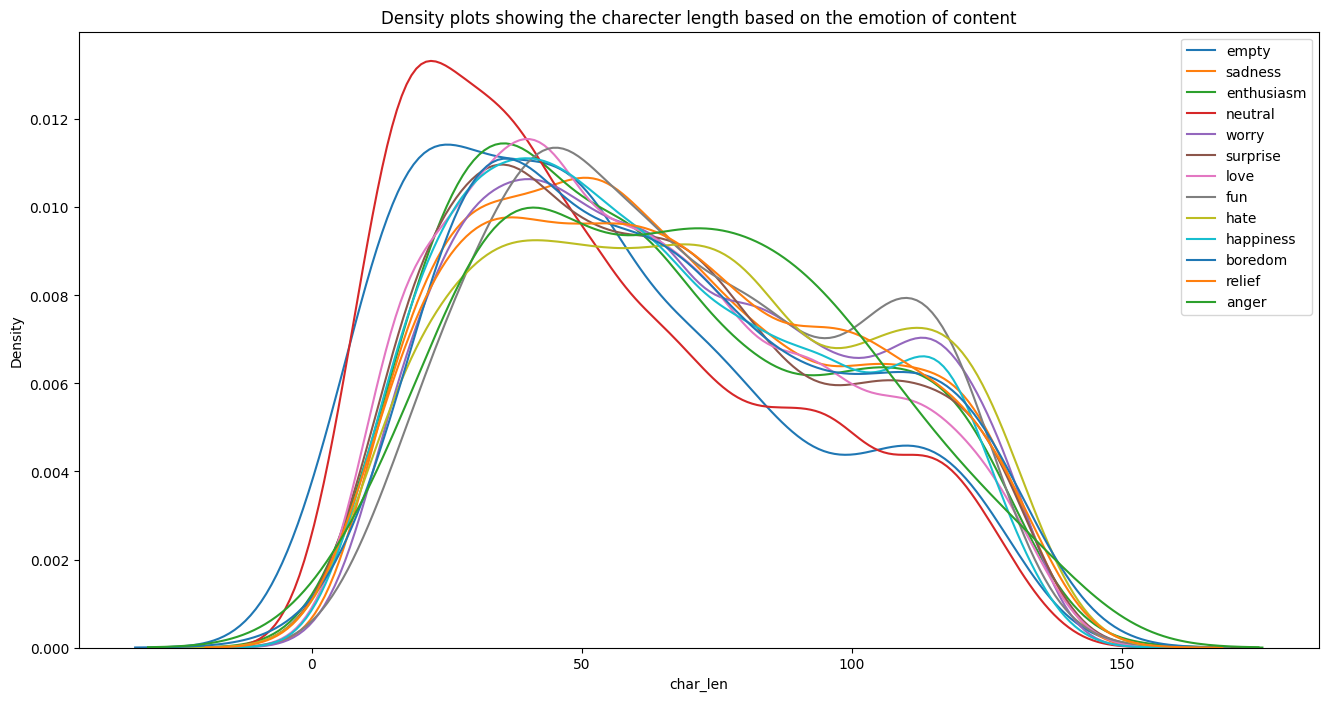

In [17]:
plt.figure(figsize=(16,8))
for emotion in list(df['sentiment'].unique()):
    sns.kdeplot(df[df.sentiment==emotion]['char_len'], 
                label = emotion)
plt.legend()
plt.title("Density plots showing the charecter length based on the emotion of content")
plt.show()

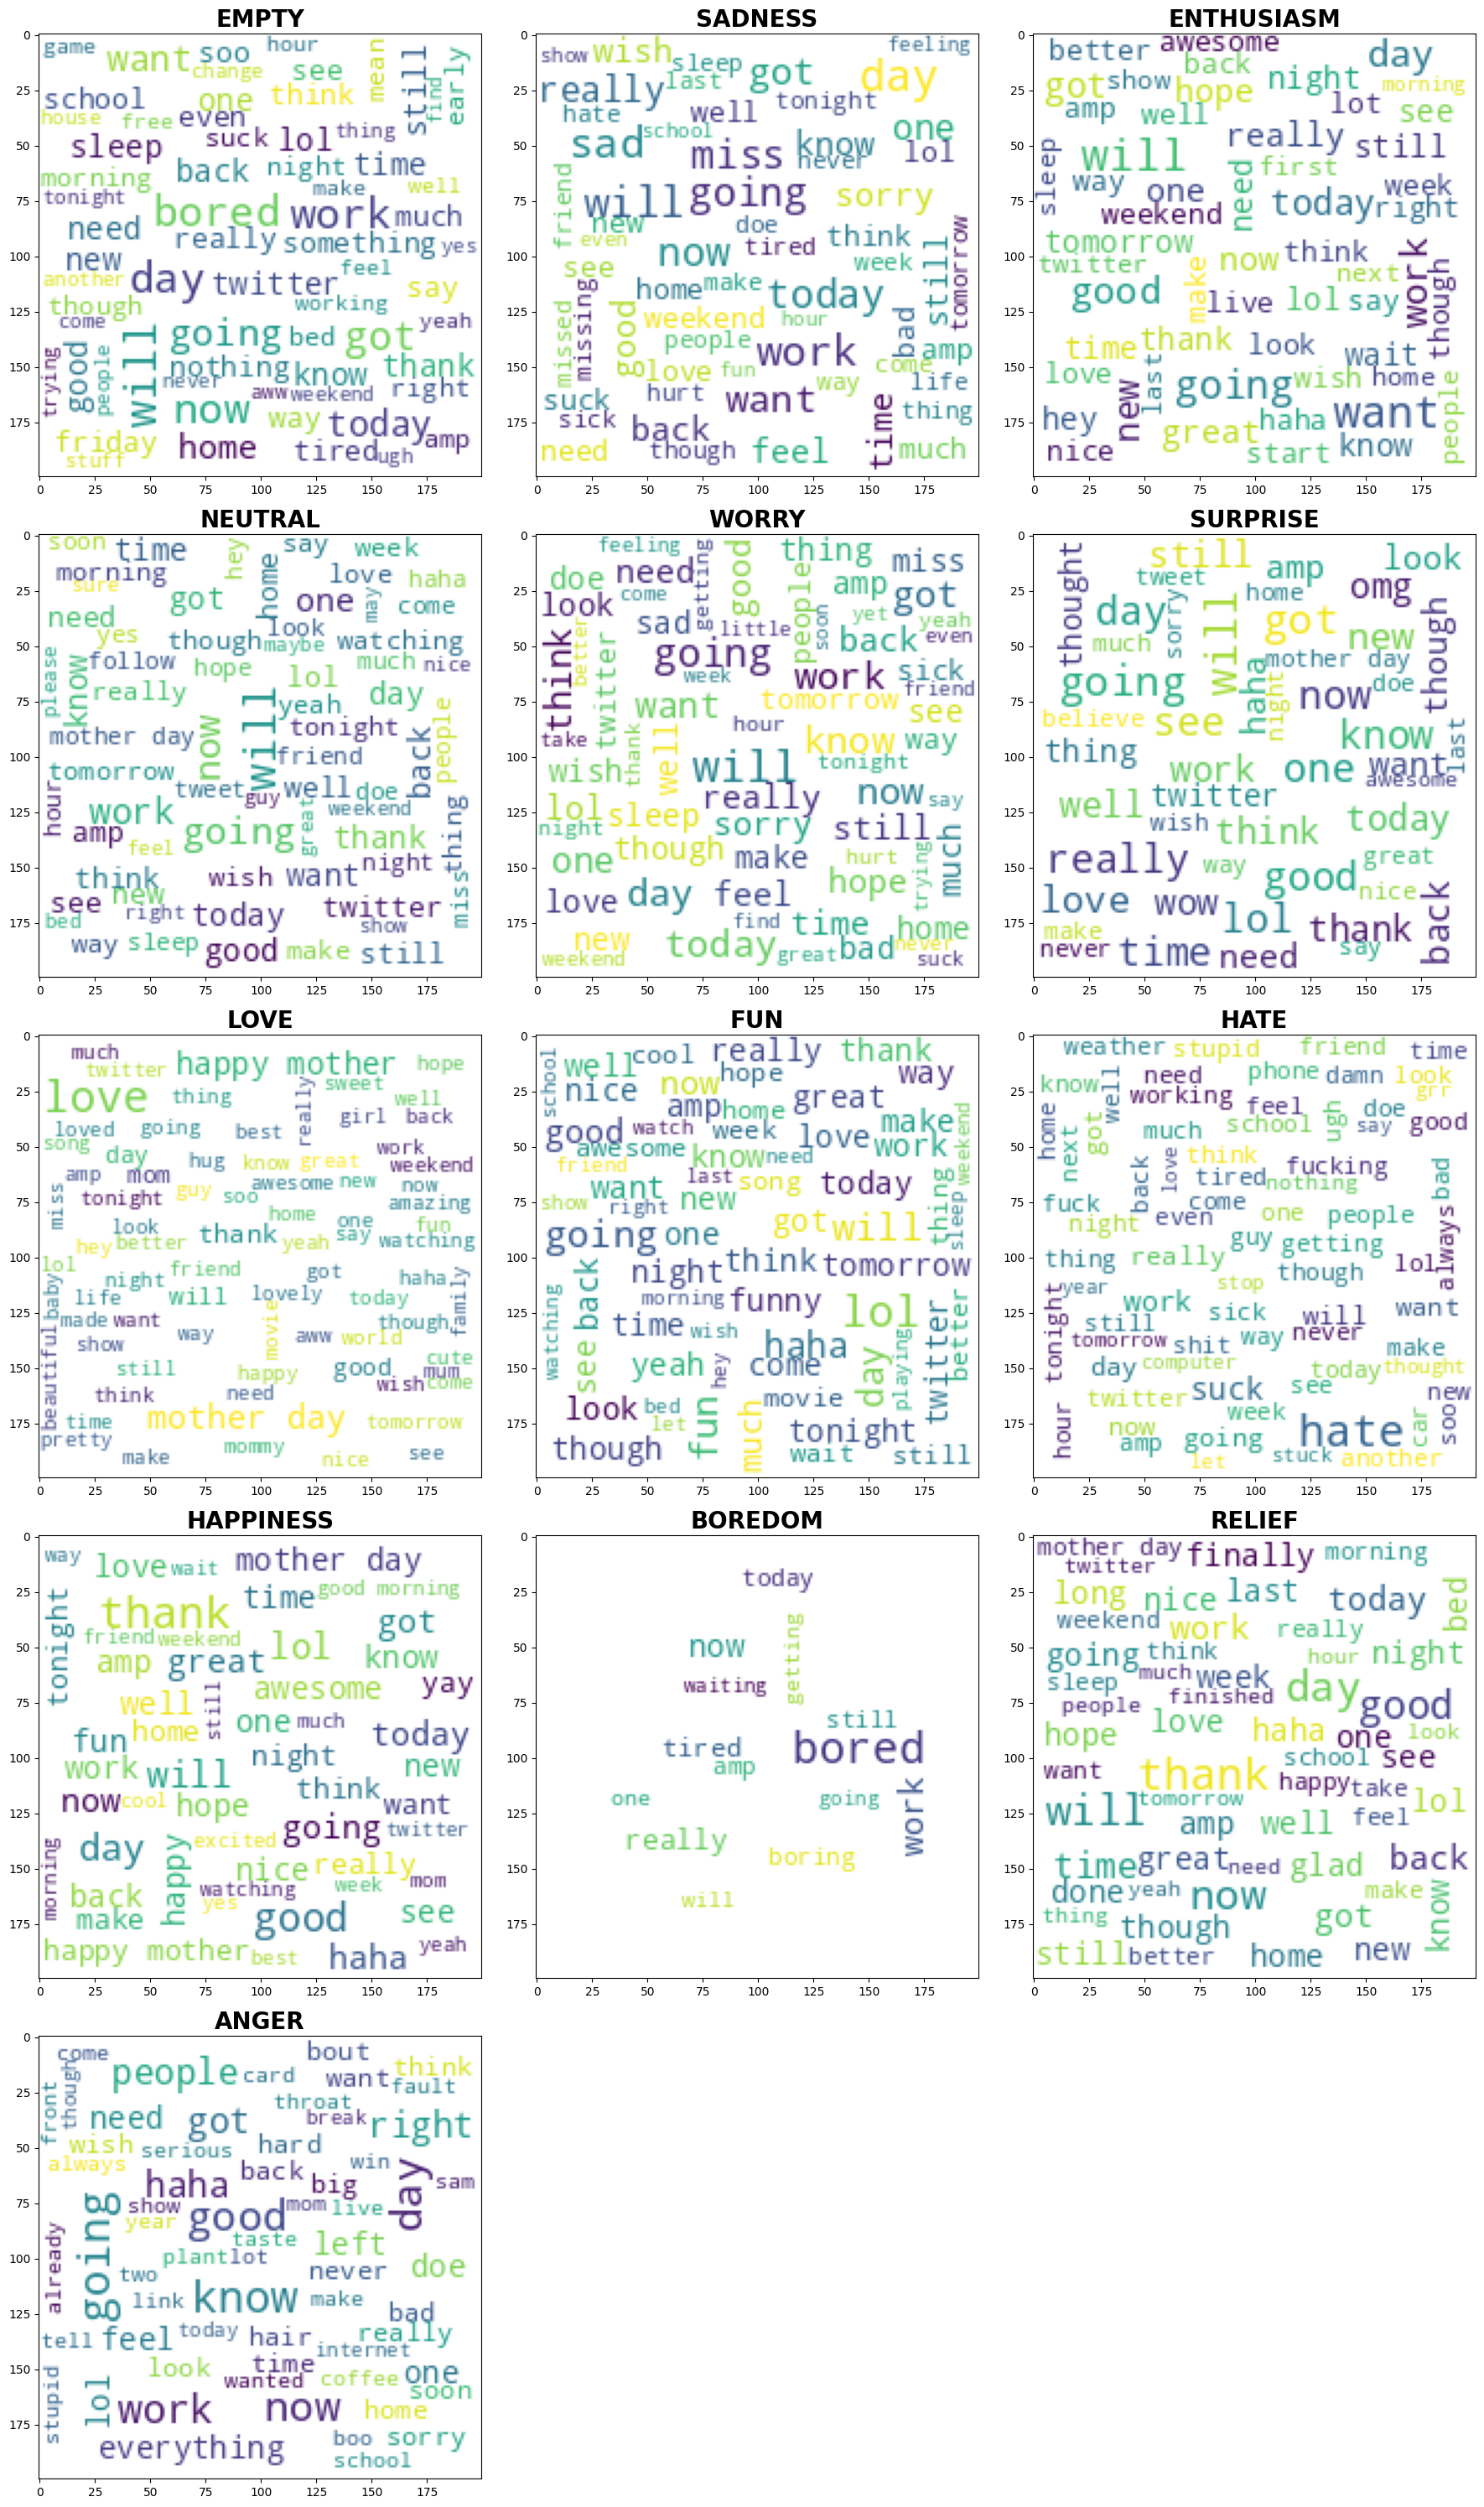

In [18]:
plot = 1
plt.subplots(4,4,figsize=(18,30), squeeze=False)
wc = WordCloud(background_color='white',max_words= 100, max_font_size=20, min_font_size=9,
               min_word_length=3, height=200, width=200)

for i in list(df['sentiment'].unique()):
    if plot<14:
        plt.subplot(5,3,plot)
        tweets = df[df['sentiment']==i]
        tweet_list = ' '.join([tweet for tweet in tweets['content'] if tweet not in stopwords.words('english')])
        wordcloud = wc.generate(tweet_list)
        plt.title(i.upper(), fontdict={'fontsize':20, 'fontweight':'bold'})
        plt.imshow(wordcloud)


        plot+=1
        
plt.tight_layout()
plt.show()

- Now that we have got a basic idea on the words people use based on their emotion, lets dive in a bit deeper and get the words that are most used based on their usage

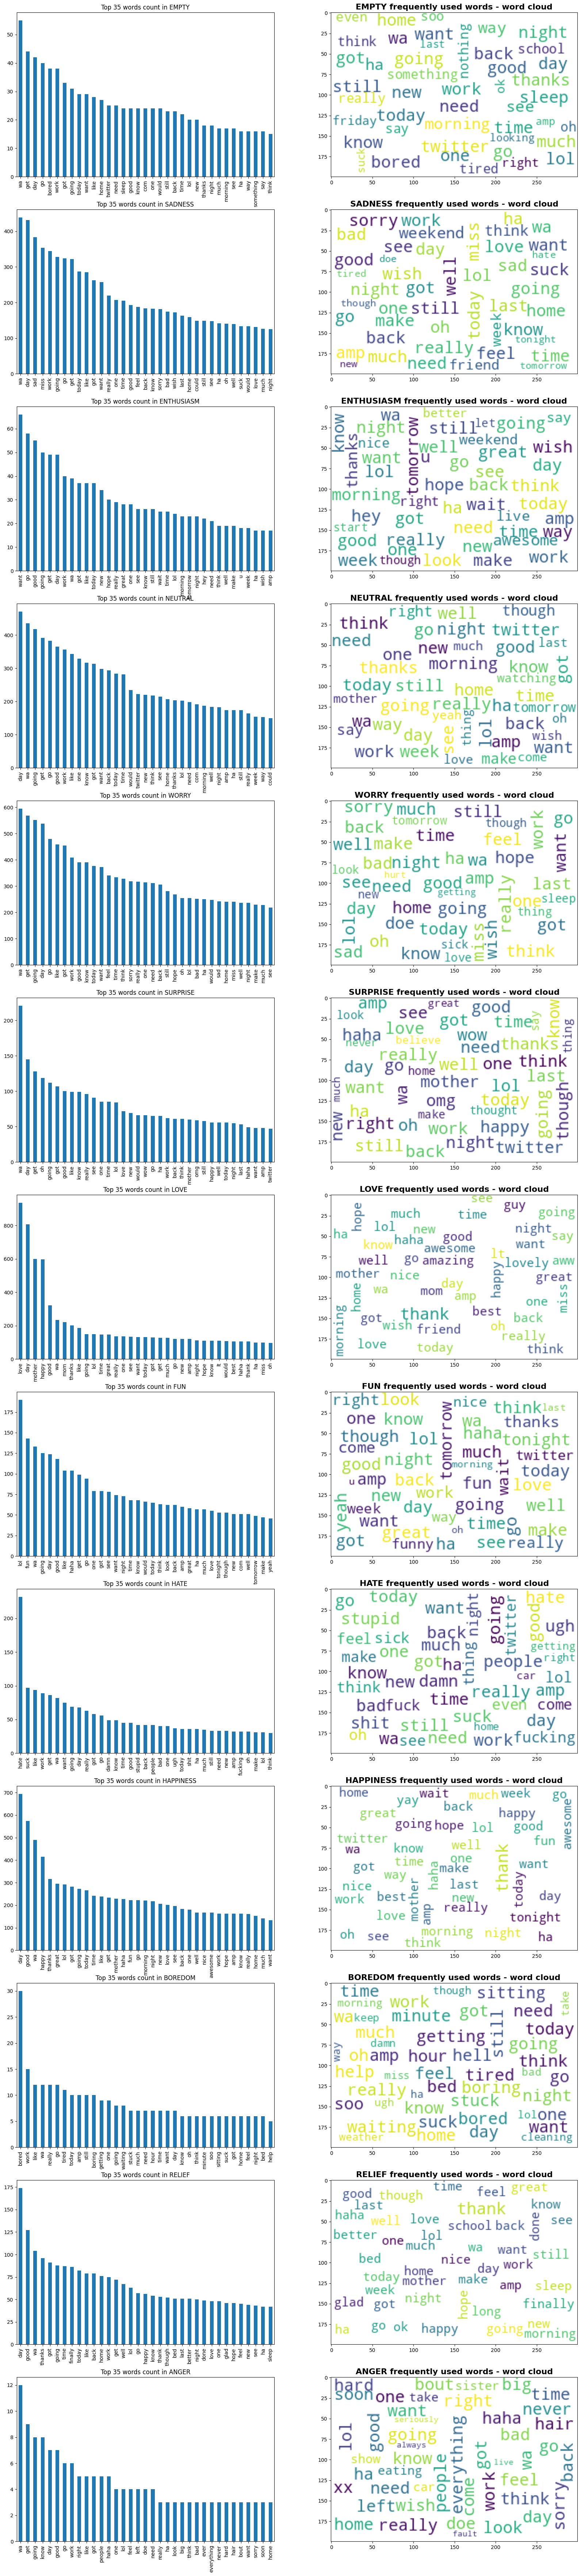

In [19]:
word_collection = {}
plt.subplots(13,2, figsize=(20,90))
col=1
for emotion in list(df['sentiment'].unique()):
    tweets = df[df['sentiment']==emotion]
    tweets_words = ' '.join([tweet for tweet in tweets['content']])

    tweets_words = nltk.word_tokenize(tweets_words)
    tweets_words = [word for word in tweets_words if word not in stopwords.words('english')]

    common_words = pd.DataFrame({'Mostly_used_words': tweets_words}, index = range(len(tweets_words)))
    word_collection[emotion] = common_words['Mostly_used_words'].value_counts()[:50] #storing top 50
    
    
    plt.subplot(13,2,col)
    word_collection[emotion][:35].plot(kind='bar')
    plt.title('Top 35 words count in {}'.format(emotion.upper()))
    col+=1
    
    plt.subplot(13,2,col)
    freq_words = ' '.join(list(word_collection[emotion].keys()))
    wordcloud = WordCloud(height=200, width=300, min_font_size=8,
                          max_font_size=20, background_color='white').generate(freq_words)
    plt.title('{} frequently used words - word cloud'.format(emotion.upper()),
             fontdict={'fontsize':16, 'fontweight':'bold'})
    plt.imshow(wordcloud)
    col+=1
    
plt.show()

- The data we have is an imbalanced data and we have least information with respect to some emotions so lets try to remove a maximum of 5% of data to prevent inducing bias in to the model and predicting the majority class neglecting the emotions with least information

In [20]:
temp = pd.DataFrame(df['sentiment'].value_counts())
temp['data_pct'] = np.cumsum(temp['sentiment']/len(df))
temp

sentiment  data_pct
neutral          8638  0.215950
worry            8459  0.427425
happiness        5209  0.557650
sadness          5165  0.686775
love             3842  0.782825
surprise         2187  0.837500
fun              1776  0.881900
relief           1526  0.920050
hate             1323  0.953125
empty             827  0.973800
enthusiasm        759  0.992775
boredom           179  0.997250
anger             110  1.000000

- From the above data we can observe that empty, enthusiasm, boredom and anger contribute least so lets replace with other emotion

In [21]:
df['sentiment'] = df['sentiment'].apply(
    lambda x : x if x in ['happiness', 'sadness', 'worry', 'neutral', 'love'] else "other") 

- The reason why we considered only 5 emotions and replaced the rest with other is that the information related to them is very least and also after modelling the the models are biased towards the rest of the emotions, so I am here replacing some of the emotions with other

In [22]:
ps = PorterStemmer()

In [23]:
def remove_stopwords(text):
    clean_text = nltk.word_tokenize(text)
    clean_text = ' '.join([ps.stem(word) for word in clean_text if word not in stopwords.words('english')\
                          and len(word)>2])
    
    return clean_text

In [24]:
df['content'] = df['content'].apply(remove_stopwords)

In [25]:
df.drop('tweet_id', axis=1, inplace=True)

In [26]:
df.drop('char_len', axis=1, inplace=True)

In [27]:
X = df.drop('sentiment', axis=1)

In [28]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X.content)

le = LabelEncoder()
y = le.fit_transform(df[['sentiment']])

In [29]:
tfidf.vocabulary_

{'know': 11514,
 'listenin': 12121,
 'bad': 1451,
 'habit': 9116,
 'earlier': 6431,
 'start': 20317,
 'freakin': 7902,
 'part': 15600,
 'layin': 11842,
 'bed': 1785,
 'headach': 9430,
 'ughh': 22476,
 'waitin': 23210,
 'call': 3008,
 'funer': 8090,
 'ceremoni': 3355,
 'gloomi': 8586,
 'friday': 7964,
 'want': 23272,
 'hang': 9270,
 'friend': 7970,
 'soon': 19936,
 'trade': 21950,
 'someon': 19897,
 'houston': 9954,
 'ticket': 21582,
 'one': 15098,
 'reping': 17972,
 'prom': 16627,
 'like': 12049,
 'sleep': 19607,
 'think': 21456,
 'old': 15041,
 'marri': 13010,
 'damn': 5305,
 'amp': 699,
 'scandal': 18724,
 'hmm': 9732,
 'djhero': 5998,
 'com': 4029,
 'charlen': 3451,
 'love': 12363,
 'miss': 13605,
 'sorri': 19967,
 'least': 11881,
 'fall': 7233,
 'asleep': 1133,
 'choke': 3652,
 'retain': 18051,
 'ugh': 22473,
 'beat': 1739,
 'stupid': 20573,
 'song': 19921,
 'get': 8428,
 'next': 14468,
 'rude': 18410,
 'watch': 23330,
 'hill': 9685,
 'london': 12251,
 'realis': 17699,
 'tourtur': 

In [30]:
len(tfidf.vocabulary_)

24628

In [31]:
np.unique(y)

array([0, 1, 2, 3, 4, 5])

In [32]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=42)

In [33]:
X_test

<8000x24628 sparse matrix of type '<class 'numpy.float64'>'
	with 50934 stored elements in Compressed Sparse Row format>

In [34]:
accuracies = {}

models = {'Multinomial Naive Bayes':MultinomialNB(), 'Logistic Regression':LogisticRegression(),
          'K Nearest Neighbors': KNei ghborsClassifier(), 'Random Forest Classifier':RandomForestClassifier(), 
          'Bagging Classifier':BaggingClassifier(), 'Ada Boost Classifier': AdaBoostClassifier(), 
          'Gradient Boosting Classifier':GradientBoostingClassifier(),
          'Decision Tree Classifier': DecisionTreeClassifier(), 'Light GBM':LGBMClassifier() 
         }

for model,clf in models.items():
    model_clf = clf
    model_clf.fit(X_train, y_train)

    model_scores = {}
    
    y_test_pred = model_clf.predict(X_test)
    y_train_pred = model_clf.predict(X_train)
    cvs = cross_val_score(model_clf, X, y, cv=5)
    print('-'*15, model)
    print('Test Score:',accuracy_score(y_test_pred, y_test), '\nCVS:', cvs.mean(),
         '\nTrain Score:',accuracy_score(y_train_pred, y_train))
    print('\nClassification Report:\n',classification_report(y_test_pred, y_test))
    print('Confusion Matrix:\n',confusion_matrix(y_test_pred, y_test))
    
    model_scores['Test_sc'] = accuracy_score(y_test_pred, y_test)
    model_scores['Train_sc'] = accuracy_score(y_train_pred, y_train)
    model_scores['CVS'] = cvs.mean()
    accuracies[model] = model_scores
    
    print('*'*100)

--------------- Multinomial Naive Bayes
Test Score: 0.310125 
CVS: 0.297675 
Train Score: 0.5186875

Classification Report:
               precision    recall  f1-score   support

           0       0.07      0.38      0.12       195
           1       0.14      0.61      0.23       180
           2       0.34      0.34      0.34      1746
           3       0.44      0.27      0.33      2858
           4       0.02      0.50      0.04        42
           5       0.55      0.31      0.40      2979

    accuracy                           0.31      8000
   macro avg       0.26      0.40      0.24      8000
weighted avg       0.44      0.31      0.35      8000

Confusion Matrix:
 [[ 74  43  24  40   3  11]
 [ 32 109  13  14   4   8]
 [236 149 586 368 139 268]
 [486 296 572 771 283 450]
 [  1   4   5   2  21   9]
 [199 161 540 563 596 920]]
****************************************************************************************************
--------------- Logistic Regression
Test Score: 0